# Моделирование по физике, первое, вторая задача
Макаров Денис Иванович, M3301

In [4]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Функции для исполнения
## Функция подсчета "интеграла"
На самом деле, она просто берет сумму "маленьких" прямоугольников
## Загрузка данных
Конфигурация программы строится на основе JSON-файла, называемый `config.json`. Можно заглянуть в его строение, чтобы понять, как можно его задавать
## Загрузка значений потенциальной энергии в пространстве
В зависимости от того, какой тип функции для нас задан для потенциальной энергии, так и определяем его. Заметим, что если задан через пары значений в файле `potential.txt`, то аналитический из `config.json` будет игнорироваться
## Определение вероятности
Потенциальный барьер произвольной формы $\displaystyle U(x)$ можно мысленно разбить на систему стоящих впритык друг к другу прямоугольных барьеров малой ширины ${\displaystyle \Delta x}$ c потенциальной энергией 
${\displaystyle U_{i}.}$ Если пренебречь отражениями на стыках, то коэффициент прохождения такой системы можно вычислить как произведение коэффициентов прохождения всех барьеров из разбиения.

${\displaystyle T=\prod T_{i}=\prod \exp \left(-{\frac {2{\sqrt {2m(U_{i}-E)}}}{\hbar }}\Delta x\right)=\exp \left(-\sum {\frac {2{\sqrt {2m(U_{i}-E)}}}{\hbar }}\Delta x\right).}$


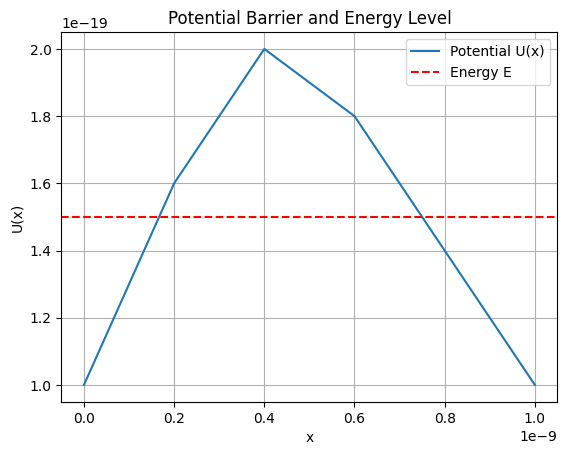

Tunneling probability: 0.19075503610237005


In [5]:
import math

hbar = 1.0545718e-34

def sum_integral(integrand, x_values):
    integrand = np.array(integrand)
    x_values = np.array(x_values)
    widths = np.diff(x_values)
    total_area = np.sum(integrand[:-1] * widths)

    return total_area


def load_config(config_path):
    with open(config_path, "r") as f:
        config = json.load(f)
    return config

def load_potential(potential_file, analytic_expression=None, x_count=1000):
    potential_data = []
    try:
        with open(potential_file, "r") as f:
            lines = f.readlines()
            for line in lines:
                x, u = map(float, line.split())
                potential_data.append((x, u))
    except FileNotFoundError:
        print(f"Potential file {potential_file} not found. Using analytic expression.")
    if not potential_data and analytic_expression:
        x_values = np.linspace(0, h, x_count)
        potential_data = [(x, analytic_expression(x)) for x in x_values]
    return np.array(potential_data)

def tunneling_probability(m, E, potential):
    x, U = potential[:, 0], potential[:, 1]

    forbidden_region = U > E
    if not np.any(forbidden_region):
        return 1.0
    
    x_forbidden = x[forbidden_region]
    U_forbidden = U[forbidden_region]
    integrand = np.sqrt(2 * m * (U_forbidden - E)) / hbar
    integral = sum_integral(integrand, x_forbidden)
    return np.exp(-2 * integral)

config = load_config("config.json")
m = config["mass"]
E = config["energy"]
h = config["barrier_range"]
x_count = config["x_count"]

analytic_expr = eval("lambda x: " + config["analytic_potential"])

potential = load_potential("potential.txt", analytic_expression=analytic_expr, x_count=x_count)

probability = tunneling_probability(m, E, potential)

plt.plot(potential[:, 0], potential[:, 1], label="Potential U(x)")
plt.axhline(E, color="red", linestyle="--", label="Energy E")
plt.xlabel("x")
plt.ylabel("U(x)")
plt.title("Potential Barrier and Energy Level")
plt.legend()
plt.grid()
plt.show()

print(f"Tunneling probability: {probability}")

# Проведем тесты
1) Первым тестом будет тест на прямоугольный потенциальный барьер. Формула аналитическая для прямоугольного потенциального барьера взята из [Википедии](https://ru.wikipedia.org/wiki/Туннельный_эффект#Прямоугольный_потенциальный_барьер)
2) Второй тест на проход без барьера

К сожалению, тяжело найти другие варианты потенциальных барьеров с их аналитическим решением.

In [6]:
def test_tunneling():
    m = 9.11e-31
    E = 1.5e-19
    U0 = 2.0e-19
    a = 1.0e-11
    x_count = 1000

    def analytic_probability():
        k = np.sqrt(2 * m * (U0 - E)) / hbar
        return 1 / (1 + (U0**2) / (4 * E * (U0 - E)) * np.sinh(k * a)**2)

    def rectangular_barrier(x):
        return U0 if 0 <= x <= a else 0

    x_values = np.linspace(-a, 2 * a, x_count)
    potential_data = [(x, rectangular_barrier(x)) for x in x_values]
    potential = np.array(potential_data)

    numerical_prob = tunneling_probability(m, E, potential)

    analytic_prob = analytic_probability()
    print(f"Numerical tunneling probability: {numerical_prob:.5e}")
    print(f"Analytic tunneling probability:  {analytic_prob:.5e}")

def test_tunneling_empty():
    m = 9.11e-31
    E = 1.5e-19
    U0 = 0
    a = 1.0e-11
    x_count = 1000

    def analytic_probability():
        return 1

    def rectangular_barrier(x):
        return U0 if 0 <= x <= a else 0

    x_values = np.linspace(-a, 2 * a, x_count)
    potential_data = [(x, rectangular_barrier(x)) for x in x_values]
    potential = np.array(potential_data)

    numerical_prob = tunneling_probability(m, E, potential)

    analytic_prob = analytic_probability()
    print(f"Numerical tunneling probability: {numerical_prob:.5e}")
    print(f"Analytic tunneling probability:  {analytic_prob:.5e}")

test_tunneling()
test_tunneling_empty()

Numerical tunneling probability: 9.44366e-01
Analytic tunneling probability:  9.98909e-01
Numerical tunneling probability: 1.00000e+00
Analytic tunneling probability:  1.00000e+00


# Первое моделирование

## Решение:
Уравнение Шредингера с помощью Гамильтониана:
$$H \psi(x) = E \psi(x)$$

Для решения задачи будем пользоваться численным методом. Сделаем следующие
допущения:
- будем считать моделируемую область X в дискретным множество из N точек.
- будем смотреть на $\psi(x)$ как на вектор значений волновой функции в каждой точке моделируемой области
- для подсчета дифференциала $d^2 \psi$

$$d^2 \psi = \psi_{i+1} - 2 \psi_i + \psi_{i-1}$$

где $\psi_i$ - значение волновой функции в $i$'ой точке моделируемой области.

Таким образом выражение $H\psi(x)$ в $i$'ой точке моделируемой области равно:

$$H \psi(x) = -\frac{\hbar^2}{2m} \frac{\psi_{i+1} - 2 \psi_i + \psi_{i-1}}{dx^2} + V(x) \psi_i$$

Гамильтониан H можно удобно представить в виде матрицы $N$ на $N$.

В крайних ячейках матрицы на главной диагонали поставим $\inf$ - это означает как бы
бесконечно высокий барьер, через который частица не сможет проскочить. Т.е.
значение в $V(x)$ на границе моделируемой области стремится к бесконечности.
Теперь задача сводится к нахождению собственных векторов у матрицы
гамильтониана. Найденные собственные числа - это значения полной энергии, а
соответствующие им собственные векторы есть ни что иное как искомые волновые
функции.
Нас интересуют только связанные состояния, т.е. где $E < 0$.


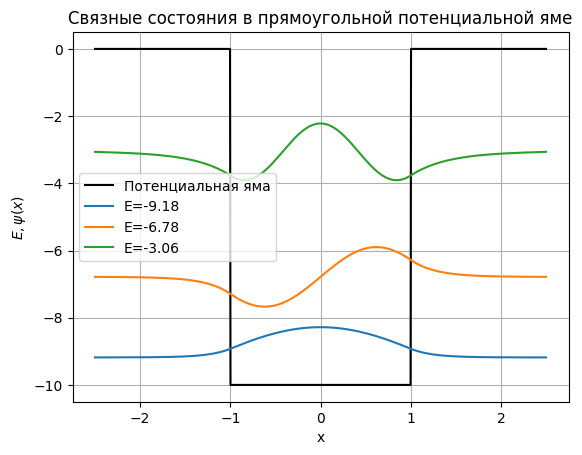

In [7]:
import numpy as np # нумпи
import matplotlib.pyplot as plt # графики
from scipy.linalg import eigh # для нахождения собственных значений


h = 1.0 # Постоянная Планка (условные единицы)
m = 1.0 # Масса частицы (условные единицы)
U = 10.0 # Глубина потенциальной ямы
a = 1.0 # Половина ширины ямы
L = 2.5 # Границы области моделирования
N = 1000 # Число точек сетки

x = np.linspace(-L, L, N)
dx = x[1] - x[0]

V = np.zeros_like(x)
V[np.abs(x) > a] = 0
V[np.abs(x) <= a] = -U

H = np.zeros((N, N))
for i in range(1, N - 1):
    H[i, i - 1] = -h ** 2 / (2 * m * dx ** 2)
    H[i, i] = h ** 2 / (m * dx ** 2) + V[i]
    H[i, i + 1] = -h ** 2 / (2 * m * dx ** 2)
    
H[0, 0] = H[-1, -1] = 1e10 #Граничное значение

eigenvalues, eigenvectors = eigh(H)


bound_states = eigenvalues[eigenvalues < 0]
bound_wavefunctions = eigenvectors[:, eigenvalues < 0]

for i in range(bound_wavefunctions.shape[1]):
    bound_wavefunctions[:, i] /= np.sqrt(np.sum(bound_wavefunctions[:,
                                                i]**2) * dx)
plt.plot(x, V, label='Потенциальная яма', color='black')
for i in range(len(bound_states)):
    E = bound_states[i]
    plt.plot(x, bound_wavefunctions[:, i] + E, label=f'E={round(E, 2)}')
plt.title("Связные состояния в прямоугольной потенциальной яме")
plt.xlabel("x")
plt.ylabel(r"$E, \psi(x)$")
plt.legend()
plt.grid()
plt.show()
